In [5]:
from superdebug import debug
from process_data import get_model_input
from train import evaluate_model, get_normalization_weights
from model import get_best_model, TransformerVoter
from utils import get_config, load_model, save_model, to_device, parse_config
import pandas as pd
import numpy as np
from collections import Counter
config = get_config("configs/subreddit_minority_no_peer.yml", "_test", print_config=False)
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
model = TransformerVoter(config, categorical_features, string_features, original_feature_map)
extra_input = (categorical_features, string_features, target)

GPU ready...
Smart using cuda:1
------------------ 2022-08-24 21:16:27 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:363 get_model_input
Loading prepared data...
------------------ 2022-08-24 21:16:27 ------------------
------------------ 2022-08-24 21:16:31 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 5.  original_token_num num val: 30522
------------------ 2022-08-24 21:16:31 ------------------
------------------ 2022-08-24 21:16:32 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 6.  latest_token_num num val: 219887
------------------ 2022-08-24 21:16:32 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
print(len(test_data), len(train_data))
test_data = test_data.iloc[:10]
test_data_info = test_data_info.iloc[:10]

365534 1462136


------------------ 2022-08-24 21:16:00 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:113 load_model
Loading latest model...
------------------ 2022-08-24 21:16:00 ------------------


100%|██████████| 1/1 [00:00<00:00, 56.15it/s]


------------------ 2022-08-24 21:16:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:256 evaluate_model
How well can the model deal with cold start problem?
------------------ 2022-08-24 21:16:01 ------------------


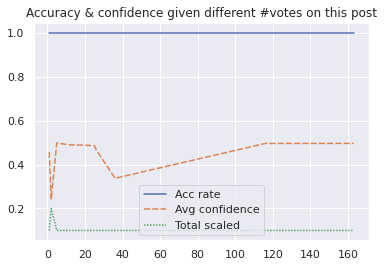

------------------ 2022-08-24 21:16:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:265 evaluate_model
How well can the model predict the lurkers' opinions?
------------------ 2022-08-24 21:16:01 ------------------


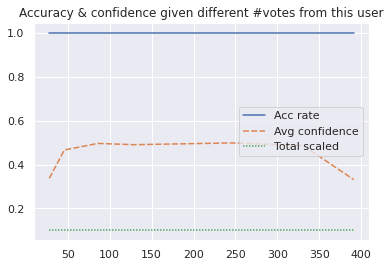

------------------ 2022-08-24 21:16:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:274 evaluate_model
How well can the model predict the minority opinions?
------------------ 2022-08-24 21:16:01 ------------------


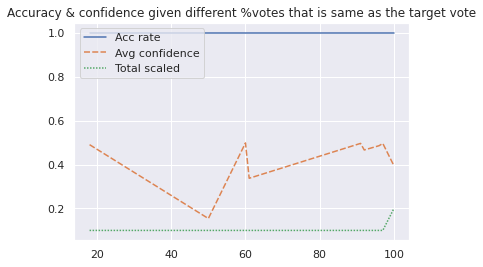

------------------ 2022-08-24 21:16:02 ------------------
DEBUG: 1 vars: ['eval_all_test_data'], at <ipython-input-3-2d0bd0ded531>:10 <module>
0 / 3.  eval_all_test_data str len 1044: - acc: 1.0 - acc_vote_0: 1.0 - acc_vote_1: 1.0 - acc_train_user_votes_num>=3: 1.0 - acc_vote_0_train_user_votes_num>=3: 1.0 - acc_vote_1_train_user_votes_num>=3: 1.0 - acc_train_submission_votes_num>=3: 1.0 - acc_vote_0_train_submission_votes_num>=3: 1.0 - acc_vote_1_train_submission_votes_num>=3: 1.0 - acc_train_submission_votes_num<=3: 1.0 - acc_vote_0_train_submission_votes_num<=3: 1.0 - acc_vote_1_train_submission_votes_num<=3: 1.0 - acc_with_weight: 1.0 - acc_vote_0_with_weight: 1.0 - acc_vote_1_with_weight: 1 ... - subreddit_acc: {} 
------------------ 2022-08-24 21:16:02 ------------------
------------------ 2022-08-24 21:16:02 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:113 load_model
Loading best model...
------------------ 2022-08-24 21:16:02 ------

100%|██████████| 1/1 [00:00<00:00, 111.00it/s]


------------------ 2022-08-24 21:16:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:256 evaluate_model
How well can the model deal with cold start problem?
------------------ 2022-08-24 21:16:03 ------------------


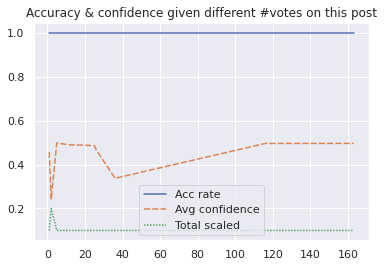

------------------ 2022-08-24 21:16:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:265 evaluate_model
How well can the model predict the lurkers' opinions?
------------------ 2022-08-24 21:16:03 ------------------


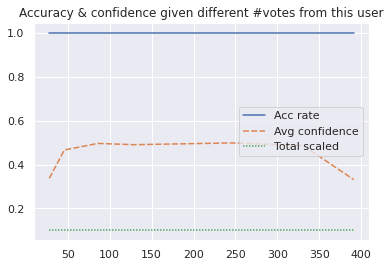

------------------ 2022-08-24 21:16:03 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:274 evaluate_model
How well can the model predict the minority opinions?
------------------ 2022-08-24 21:16:03 ------------------


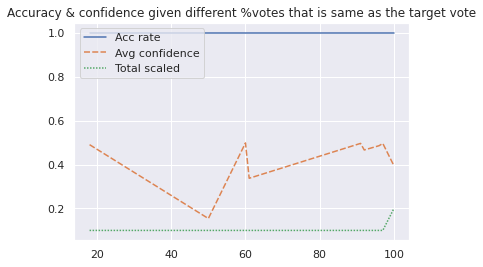

------------------ 2022-08-24 21:16:04 ------------------
DEBUG: 1 vars: ['eval_all_test_data'], at <ipython-input-3-2d0bd0ded531>:10 <module>
0 / 4.  eval_all_test_data str len 1044: - acc: 1.0 - acc_vote_0: 1.0 - acc_vote_1: 1.0 - acc_train_user_votes_num>=3: 1.0 - acc_vote_0_train_user_votes_num>=3: 1.0 - acc_vote_1_train_user_votes_num>=3: 1.0 - acc_train_submission_votes_num>=3: 1.0 - acc_vote_0_train_submission_votes_num>=3: 1.0 - acc_vote_1_train_submission_votes_num>=3: 1.0 - acc_train_submission_votes_num<=3: 1.0 - acc_vote_0_train_submission_votes_num<=3: 1.0 - acc_vote_1_train_submission_votes_num<=3: 1.0 - acc_with_weight: 1.0 - acc_vote_0_with_weight: 1.0 - acc_vote_1_with_weight: 1 ... - subreddit_acc: {} 
------------------ 2022-08-24 21:16:04 ------------------


In [3]:
model_types = ["latest", "best"]
for model_type in model_types:
    model, _, _, _, _ = load_model(config["save_model_dir"], model, model.optim, 0, 0, model_type)
    model.to(model.device)
    test_weights = get_normalization_weights(test_data, train_submission_upvote_df, config)
    if config["use_voted_users_feature"]:
        debug("Use all voted users as feature")
    eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=False, extra_input=extra_input, data_info = test_data_info, simple = False)
    eval_result_str = "".join([f"- {key}: {value:.4f} " if type(value) in [int, float] else f"- {key}: {value} " for key, value in eval_all_test_data.items()])
    debug(eval_all_test_data=eval_result_str)
    with open(config["log_path"], 'a') as log:
        log.write(f"Evaluation result of the {model_type} model (use all voted users as feature):" + eval_result_str+"\n")

    if config["use_voted_users_feature"] and config["sample_part_voted_users"]:
        debug("Sample part voted users as feature")
        eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=True, extra_input=extra_input, data_info = test_data_info, simple = False)
        eval_result_str = "".join([f"- {key}: {value:.4f} " for key, value in eval_all_test_data.items()])
        debug(eval_all_test_data=eval_result_str)
        with open(config["log_path"], 'a') as log:
            log.write(f"Evaluation result of the {model_type} model (sample part voted users as feature):" + eval_result_str+"\n")
    
    model.cpu()